# Main File to train Model on Hierarchical Bi-LSTM 

### Import necessary dependencies and random seed

In [ ]:
import numpy as np
from collections import defaultdict
import re
import random
import sys
import os
import pandas as pd

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Concatenate, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.layers.normalization import BatchNormalization
from keras.layers import merge
from keras.layers import concatenate
from keras.models import model_from_json


from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
from numpy.random import seed
seed(70)


## Get view of data

In [2]:
df = pd.read_csv("semantic_feature_.csv")
df.head(5)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,user,Message-ID,new_content,doc,nr_sentences,avg_number_of_words_per_sent,std_deviation_len,...,most_frequency,nr_pos,nr_function,avg_length_np,nr_positive_word,nr_neg_word,nr_neutral_word,nr_named_entity,score_semantic,nr_greeting
0,0,0,0,germany-c,<25069561.1075853799771.JavaMail.evans@thyme>,Call me $,Call me $,1.0,2.000000,0.000000,...,1.0,3.0,1.0,2.000000,0.0,0.0,3.0,0.0,0.0000,0.0
1,1,1,1,germany-c,<30565676.1075845146575.JavaMail.evans@thyme>,"Chris,\n\nPlease extend this deal to 12/31/00....","Chris,\n\nPlease extend this deal to 12/31/00....",3.0,3.333333,3.785939,...,1.0,11.0,6.0,6.250000,3.0,0.0,11.0,5.0,0.7096,0.0
2,2,2,2,germany-c,<22843742.1075853701854.JavaMail.evans@thyme>,The Unify tables are updated for the fuel chan...,The Unify tables are updated for the fuel chan...,2.0,13.000000,2.121320,...,2.0,11.0,12.0,11.250000,1.0,0.0,26.0,2.0,0.4767,0.0
3,3,3,3,germany-c,<10021489.1075853845389.JavaMail.evans@thyme>,I'm a bad person. I forgot to tell you I sold...,I'm a bad person. I forgot to tell you I sold...,5.0,7.800000,7.949843,...,5.0,14.0,20.0,5.312500,0.0,1.0,46.0,15.0,-0.5423,0.0
4,4,4,4,germany-c,<4513779.1075853857752.JavaMail.evans@thyme>,"After talking to Victor, he said this was the ...","After talking to Victor, he said this was the ...",6.0,8.666667,7.823043,...,5.0,14.0,27.0,8.578947,2.0,0.0,58.0,12.0,0.6808,0.0


### Drop Unnecessary columns from dataframe

In [3]:
df.drop(df.columns[[1, 2]], axis = 1, inplace = True) 

In [4]:
df.head(5)

,Unnamed: 0,user,Message-ID,new_content,doc,nr_sentences,avg_number_of_words_per_sent,std_deviation_len,nr_chars,nr_alphabet,...,most_frequency,nr_pos,nr_function,avg_length_np,nr_positive_word,nr_neg_word,nr_neutral_word,nr_named_entity,score_semantic,nr_greeting
0,0,germany-c,<25069561.1075853799771.JavaMail.evans@thyme>,Call me $,Call me $,1.0,2.000000,0.000000,7,6,...,1.0,3.0,1.0,2.000000,0.0,0.0,3.0,0.0,0.0000,0.0
1,1,germany-c,<30565676.1075845146575.JavaMail.evans@thyme>,"Chris,\n\nPlease extend this deal to 12/31/00....","Chris,\n\nPlease extend this deal to 12/31/00....",3.0,3.333333,3.785939,84,55,...,1.0,11.0,6.0,6.250000,3.0,0.0,11.0,5.0,0.7096,0.0
2,2,germany-c,<22843742.1075853701854.JavaMail.evans@thyme>,The Unify tables are updated for the fuel chan...,The Unify tables are updated for the fuel chan...,2.0,13.000000,2.121320,142,132,...,2.0,11.0,12.0,11.250000,1.0,0.0,26.0,2.0,0.4767,0.0
3,3,germany-c,<10021489.1075853845389.JavaMail.evans@thyme>,I'm a bad person. I forgot to tell you I sold...,I'm a bad person. I forgot to tell you I sold...,5.0,7.800000,7.949843,201,165,...,5.0,14.0,20.0,5.312500,0.0,1.0,46.0,15.0,-0.5423,0.0
4,4,germany-c,<4513779.1075853857752.JavaMail.evans@thyme>,"After talking to Victor, he said this was the ...","After talking to Victor, he said this was the ...",6.0,8.666667,7.823043,287,277,...,5.0,14.0,27.0,8.578947,2.0,0.0,58.0,12.0,0.6808,0.0


In [5]:
df.drop(df.columns[[0,2,4]], axis = 1, inplace = True) 

In [6]:
df.head(5)

,user,new_content,nr_sentences,avg_number_of_words_per_sent,std_deviation_len,nr_chars,nr_alphabet,nr_upper,nr_lower,nr_numerics,...,most_frequency,nr_pos,nr_function,avg_length_np,nr_positive_word,nr_neg_word,nr_neutral_word,nr_named_entity,score_semantic,nr_greeting
0,germany-c,Call me $,1.0,2.000000,0.000000,7,6,1,5,0,...,1.0,3.0,1.0,2.000000,0.0,0.0,3.0,0.0,0.0000,0.0
1,germany-c,"Chris,\n\nPlease extend this deal to 12/31/00....",3.0,3.333333,3.785939,84,55,5,50,18,...,1.0,11.0,6.0,6.250000,3.0,0.0,11.0,5.0,0.7096,0.0
2,germany-c,The Unify tables are updated for the fuel chan...,2.0,13.000000,2.121320,142,132,11,121,6,...,2.0,11.0,12.0,11.250000,1.0,0.0,26.0,2.0,0.4767,0.0
3,germany-c,I'm a bad person. I forgot to tell you I sold...,5.0,7.800000,7.949843,201,165,19,146,27,...,5.0,14.0,20.0,5.312500,0.0,1.0,46.0,15.0,-0.5423,0.0
4,germany-c,"After talking to Victor, he said this was the ...",6.0,8.666667,7.823043,287,277,14,263,0,...,5.0,14.0,27.0,8.578947,2.0,0.0,58.0,12.0,0.6808,0.0


### initial parameters for Tokenization and word indexing

In [7]:
# hyper parameters
max_sen_len = 150
max_sents = 50
emb_dim = 100
val_split = 0.2
test_split = 0.2

In [8]:
lines = []
labels = []
texts = []
f_names = []
style_vectors = []
scd = []
style_dict = {}
classes = []
class_labels = {}
class_ind = 0
style_train = []
style_val = []

### Fill various matrices with style vectors

In [9]:
count = 0
curr_user = "germany-c"
for _, doc in df.iterrows():
    if doc["user"] != curr_user:
        print(count)
        print(doc["user"])
        count = 0
        curr_user = doc["user"]
    s_key = doc["user"] + str(count)
    lst = doc[2:].values.tolist()
    s_value =  lst
    style_dict[s_key] = s_value
    count += 1
    style_vectors.append(s_value)

10163
beck-s
10434
kaminski-v
20719
kean-s
13851
symes-k
9455
dasovich-j
18087
mann-k
20622
farmer-d
11768
jones-t
12222
shackleton-s


In [10]:
var = style_vectors[1]
print(type(var))
print(len(style_dict))
print(len(style_vectors))

<class 'list'>
140651
140651


In [11]:
classes = []
class_labels = {}
class_index = 0

### Create Unique list of all users

In [12]:
users_lst = df["user"].values.tolist()
uniq_users = []
for user in users_lst:
    if user not in uniq_users:
        uniq_users.append(user)
for author in uniq_users:
    classes.append(author)
    class_labels[author] = class_index
    class_index += 1
print(classes)
print(class_labels)

['germany-c', 'beck-s', 'kaminski-v', 'kean-s', 'symes-k', 'dasovich-j', 'mann-k', 'farmer-d', 'jones-t', 'shackleton-s']
{'germany-c': 0, 'beck-s': 1, 'kaminski-v': 2, 'kean-s': 3, 'symes-k': 4, 'dasovich-j': 5, 'mann-k': 6, 'farmer-d': 7, 'jones-t': 8, 'shackleton-s': 9}


### Create vectors of email text and labels

In [13]:
for user,doc in df.iterrows():
    text = str(doc["new_content"])
    #print(text.lower().split("\n"))
    sentences = text.lower().split("\n")
    #print(sentences)
    lines.append(sentences)
    text = text.lower().replace("\n", " ")
    labels.append(class_labels[str(doc["user"])])
    texts.append(text)
       
print(texts[:5])
print(lines[:5])
print(labels[:5])

['call me $', 'chris,  please extend this deal to 12/31/00.  we had gas flow from 12/22/00 - 12/31/00.  thanks,  sherry', 'the unify tables are updated for the fuel changes on cgas and cglf effective  4/1/2000. attached is a spreadsheet with the calculations for zone to zone fuel  percentages.', "i'm a bad person.  i forgot to tell you i sold ces 880 to 1000 day at the  pool starting tomorrow on deal 217775  also, i just sold ces 2500/day at cglf mainline starting the 16th-31st, deal  217854.  this gas is for atistech.  i assume we schedule that.      ", "after talking to victor, he said this was the correct process. i'm thinking  joann  can update the ces and calp tickets in the morning when she runs the  new navigator reports. joann can also update dayton's ticket in the afternoon  from our spreadsheet or steve's.   joann, let me or robert know if you need some help in updating these tickets.  thanks. "]
[['call me $'], ['chris,', '', 'please extend this deal to 12/31/00.  we had gas

### Convert the style vectors in an NP array

In [14]:
style_vectors = np.array(style_vectors)
print(style_vectors[:5])

[[  1.           2.           0.           7.           6.
    1.           5.           0.           2.           1.
    0.           0.           0.           0.           0.
    0.           0.           1.           1.           3.
    3.           3.           0.           1.           0.
    1.           1.           1.           3.           1.
    2.           0.           0.           3.           0.
    0.           0.        ]
 [  3.           3.33333333   3.7859389   84.          55.
    5.          50.          18.          20.          11.
    2.           2.           0.           0.           0.
    0.           1.           4.           1.25         4.25
   17.           5.76470588   1.           4.           0.
    1.           1.           1.          11.           6.
    6.25         3.           0.          11.           5.
    0.7096       0.        ]
 [  2.          13.           2.12132034 142.         132.
   11.         121.           6.          29.          

### Normalize style vector values

In [15]:
style_vectors = style_vectors / style_vectors.max(axis=0)

In [16]:
print(style_vectors[:5])

[[ 2.58197779e-04  2.43902439e-02  0.00000000e+00  3.50555631e-05
   3.28109107e-05  1.48705518e-05  2.97711196e-05  0.00000000e+00
   5.07150827e-05  5.97157530e-05  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  7.26216412e-04  3.99520575e-04  2.71837622e-04
   8.05823417e-05  1.07526882e-02  0.00000000e+00  9.11327805e-05
   0.00000000e+00  1.00000000e+00  1.00000000e+00  5.60224090e-04
   1.66666667e-01  7.53068755e-05  7.16845878e-03  0.00000000e+00
   0.00000000e+00  9.59692898e-05  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 7.74593338e-04  4.06504065e-02  2.34830094e-02  4.20666757e-04
   3.00766682e-04  7.43527592e-05  2.97711196e-04  2.19244823e-03
   5.07150827e-04  6.56873283e-04  8.89679715e-04  2.58097819e-04
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00704935e-03  2.90486565e-03  4.99400719e-04  3.85103298e-04
   4.56633270e-04  2.06620283e-02  1.23808345e-04  3.6453

### Create Tokenizer from the email content and create data vector with its representation

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
data = np.zeros((len(texts), max_sents, max_sen_len), dtype='int32')
for i,sentences in enumerate(lines):
    for j, sent in enumerate(sentences):
        #print(i,j,sent)
        if j < max_sents:
            word_tokens = text_to_word_sequence(sent)
            k = 0
            for _, word in enumerate(word_tokens):
                if k < max_sen_len:
                    data[i, j, k] = tokenizer.word_index[word]
                    k += 1

### Create word index from the tokenizer and convert the labels to np array

In [19]:
word_index = tokenizer.word_index
labels = to_categorical(np.asarray(labels))

### Random shuffle the data

In [20]:
print(data.shape[0])
indices = np.arange(data.shape[0])
print(indices)
print(type(labels))
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
style_vectors = style_vectors[indices]

140651
[     0      1      2 ... 140648 140649 140650]
<class 'numpy.ndarray'>


### Split the data into train validation and test data

In [22]:
val_split = 0.2
test_split = 0.2
nb_validation_samples = int(val_split * data.shape[0])
print(nb_validation_samples)
nb_test_samples = int(test_split * data.shape[0])
print(nb_test_samples)
x_train, x_val, x_test = np.split(data, [int(.6*len(data)), int(.8*len(data))])
y_train, y_val, y_test = np.split(labels, [int(.6*len(data)), int(.8*len(data))])
style_train, style_val, style_test = np.split(style_vectors, [int(.6*len(data)), int(.8*len(data))])
print(len(x_train), len(x_val), len(x_test))
print(len(y_train), len(y_val), len(y_test))
print(len(style_train), len(style_val), len(style_test))

28130
28130
84390 28130 28131
84390 28130 28131
84390 28130 28131


### Use glove to find out the direction of the word in the infinite vector space

In [23]:
embeddings_index = {}
with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

### create embedding matrix 

In [24]:
embedding_matrix = np.random.random((len(word_index) + 1, emb_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

#### create LSTM model 

In [38]:
embedding_layer = Embedding(len(word_index) + 1,
                            emb_dim,
                            weights=[embedding_matrix],
                            input_length=max_sen_len,
                            trainable=True)

# Bidirectional LSTM
sentence_input = Input(shape=(max_sen_len,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)

# Bidirectional LSTM
sentEncoder = Model(sentence_input, l_lstm)
email_input = Input(shape=(max_sents,max_sen_len), dtype='int32')
email_encoder = TimeDistributed(sentEncoder)(email_input)
l_lstm_sent = Bidirectional(LSTM(100))(email_encoder)

# Input the stylometric feature
auxiliary_input = Input(shape=(37,))

# Concatenate with lstm output
x_new = concatenate([l_lstm_sent, auxiliary_input])

# Dense layer
dense_1 = Dense(128, activation='relu')(x_new)

# Dropout layer
drop_1 = Dropout(0.3)(dense_1)

# Final Dense layer
preds = Dense(10, activation='softmax')(drop_1)

# Model
model = Model(inputs=[email_input, auxiliary_input], outputs=preds)

### Compile model with Categorical cross entrop and create callbacks to prevent overfitting.

In [39]:

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#final_weights_path = os.path.join(os.getcwd(),"/weights")
#callbacks_list = [EarlyStopping(monitor='val_acc', patience=4, verbose=0)]
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
callbacks_list = [ModelCheckpoint(filepath,
                            monitor='val_accuracy',
                            verbose=1,
                            save_best_only=True,
                            mode='max'),
                      EarlyStopping(monitor='val_accuracy', patience=3, verbose=0)]

In [37]:
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 50, 150)      0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 50, 200)      14955000    input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 200)          240800      time_distributed_1[0][0]         
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 37)           0                                            
____________________________________________________________________________________________

### train the model

In [ ]:
model.fit(x=[x_train, style_train], y=y_train, validation_data=([x_val, style_val], y_val), epochs=30, batch_size=32, callbacks = callbacks_list)

In [32]:
import h5py
model_json = model.to_json()
with open("model_stylo_1.json", "w") as json_file:
    json_file.write(model_json)

In [23]:
json_file = open('model_stylo_1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("weights-improvement-03-0.84.hdf5")
model = loaded_model

In [24]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#final_weights_path = os.path.join(os.getcwd(),"/weights")
#callbacks_list = [EarlyStopping(monitor='val_acc', patience=4, verbose=0)]
filepath="Weights/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
callbacks_list = [ModelCheckpoint(filepath,
                            monitor='val_accuracy',
                            verbose=1,
                            save_best_only=True,
                            mode='max'),
                      EarlyStopping(monitor='val_accuracy', patience=3, verbose=0)]

In [23]:
json_file = open('model_stylo_1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("Weights/weights-improvement-19-0.88.hdf5")
model = loaded_model

In [24]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
callbacks_list = [ModelCheckpoint(filepath,
                            monitor='val_accuracy',
                            verbose=1,
                            save_best_only=True,
                            mode='max'),
                      EarlyStopping(monitor='val_accuracy', patience=2, verbose=0)]

In [25]:
x = model.predict([x_test,style_test])

In [26]:
print(len(x))

28131


In [27]:
y_true = np.argmax(y_test, axis = 1)
print(y_true)
print("dnsad")
print(len(y_true))

[8 7 4 ... 5 3 5]
dnsad
28131


In [28]:
print(np.argmax(x, axis = 1))
y_preds = np.argmax(x, axis = 1)
print("fdsfds")
print(len(y_preds))

[8 7 8 ... 3 3 5]
fdsfds
28131


In [33]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues,true=0):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.suptitle(title)

    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks([0, 1, 2, 3, 4,5,6,7,8,9], classes, rotation=45)
    plt.yticks([0, 1, 2, 3, 4,5,6,7,8,9], classes)

    classifiction_accuracy = (true/28131) * 100

    print(true)
    print(classifiction_accuracy)

    cm_accuracy = np.trace(cm) / np.sum(cm)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # for normalization
    # cm_accuracy = np.around((cm_accuracy,2)) * 100
    plt.title('Accuracy :  ' + str(classifiction_accuracy))

    thresh = cm.max() / 2.
    np.set_printoptions(precision=2)
    cm = np.around(cm, 2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    figure = plt.gcf() # get current figure
    figure.set_size_inches(12, 12)

    plt.savefig('Confusion_Matrix_final_1.png')
    plt.show()
    return 

In [30]:
y_act = list(y_true)
y_pred = list(y_preds)

print(len(y_act), len(y_pred))

28131 28131


In [31]:
correct = 0
for i in range(len(y_act)):

    if(y_act[i]==y_pred[i]):
        correct+=1
print(correct)
print(len(y_act))
print(correct/len(y_act))

26157
28131
0.929828303295297


26157
92.98283032952969


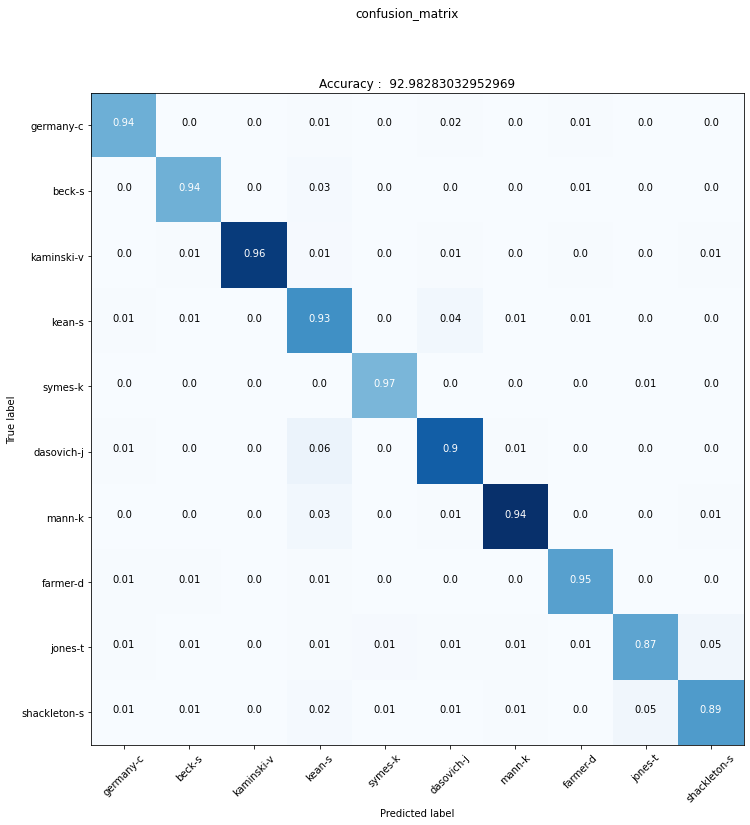

In [34]:
import itertools
from sklearn.metrics import confusion_matrix,classification_report

cnf_matrix = confusion_matrix( y_true = y_true, y_pred = y_pred )
plot_confusion_matrix(cnf_matrix, uniq_users, title='confusion_matrix', true=correct)

In [38]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_true, y_pred, average='weighted')

(0.9318417765466522, 0.929828303295297, 0.9302888754279421, None)

In [39]:
print(classification_report(y_true, y_pred, target_names=uniq_users))

              precision    recall  f1-score   support

   germany-c       0.94      0.94      0.94      2093
      beck-s       0.94      0.94      0.94      2085
  kaminski-v       0.99      0.96      0.97      3983
      kean-s       0.81      0.93      0.86      2725
     symes-k       0.95      0.97      0.96      1913
  dasovich-j       0.92      0.90      0.91      3653
      mann-k       0.97      0.94      0.96      4237
    farmer-d       0.95      0.95      0.95      2349
     jones-t       0.92      0.87      0.90      2470
shackleton-s       0.91      0.89      0.90      2623

    accuracy                           0.93     28131
   macro avg       0.93      0.93      0.93     28131
weighted avg       0.93      0.93      0.93     28131

